In [1]:
import numpy as np
import sklearn
import scipy.stats
import matplotlib
matplotlib.use('PDF')
%matplotlib inline
import matplotlib.pyplot as plt
import timeit
import pandas as pd
import math
import itertools
import time

import sklearn.neighbors
from sklearn.neighbors import (
    KernelDensity,
    KDTree,
)

In [2]:
df = pd.read_csv("../../data/shuttle.csv")

In [3]:
def estimate_kde_bw(data):
    q3 = np.percentile(data, 75, axis=0)
    q1 = np.percentile(data, 25, axis=0)
    iqr = q3 - q1
    bw = iqr * (data.shape[0])**(-1.0/(data.shape[1]+4))
    return bw

In [10]:
df.head()

,0,1,2,3,4,5,6,7,8,label
0,50,21,77,0,28,0,27,48,22,2
1,55,0,92,0,0,26,36,92,56,4
2,53,0,82,0,52,-5,29,30,2,1
3,37,0,76,0,28,18,40,48,8,1
4,37,0,79,0,34,-26,43,46,2,1


In [4]:
bw = estimate_kde_bw(df[[4,6]])
data = df[[4,6]].values/bw

In [5]:
tol = .1
kde = KernelDensity(
    bandwidth=.2,
    kernel='gaussian',
    algorithm='kd_tree',
    rtol=tol,
)
kde.fit(data)
kde_scores = kde.score_samples(data)
threshold = np.percentile(kde_scores, .3)
outliers = kde_scores < threshold

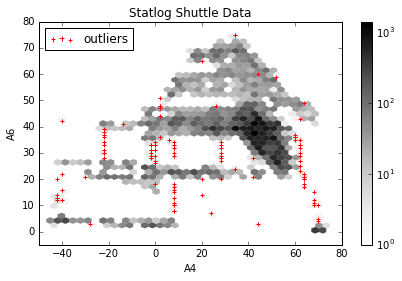

In [51]:
fig = plt.figure(figsize=(6,4), dpi=300)
plt.hexbin(
    df[[4]], df[[6]], 
    extent=(-50,80,-5,80), gridsize=40, 
    linewidths=(.2,), norm=matplotlib.colors.LogNorm(), cmap='Greys')
plt.colorbar()
plt.scatter(df[outliers][[4]], df[outliers][[6]], marker='+', c='r', label="outliers")
plt.legend(loc=2)
plt.xlim(-50,80)
plt.ylim(-5,80)
plt.xlabel("A4")
plt.ylabel("A6")
plt.title("Statlog Shuttle Data")
fig.tight_layout()
plt.savefig("shuttle_w_outliers.pdf")

# Gaussian

In [7]:
import sklearn.covariance

In [21]:
mcd = sklearn.covariance.EmpiricalCovariance()
mcd.fit(df[[4,6]])

EmpiricalCovariance(assume_centered=False, store_precision=True)

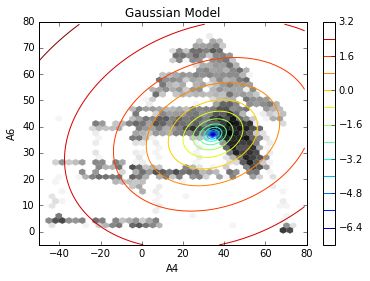

In [29]:
x = np.arange(-50,80,1)
y = np.arange(-5,80,1)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=math.log(mcd.mahalanobis([[X[i,j],Y[i,j]]])[0])
plt.contour(X,Y,Z,15)
plt.colorbar()
plt.hexbin(
    df[[4]], df[[6]], 
    extent=(-50,80,-5,80), gridsize=40, 
    linewidths=(.2,), norm=matplotlib.colors.LogNorm(), cmap='Greys')
plt.title("Gaussian Model")
plt.xlabel("A4")
plt.ylabel("A6")
plt.savefig("shuttlegauss.pdf")

# Multi Gauss

In [17]:
import sklearn.mixture

In [26]:
k=5
gmm = sklearn.mixture.GaussianMixture(
    n_components=k,
    covariance_type="full",
    random_state=0,
)
gmm.fit(df[[4,6]])

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

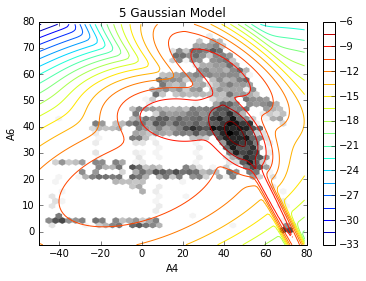

In [30]:
x = np.arange(-50,80,1)
y = np.arange(-5,80,1)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=gmm.score_samples([[X[i,j],Y[i,j]]])[0]
plt.contour(X,Y,Z,25)
plt.colorbar()
plt.hexbin(
    df[[4]], df[[6]], 
    extent=(-50,80,-5,80), gridsize=40, 
    linewidths=(.2,), norm=matplotlib.colors.LogNorm(), cmap='Greys')
plt.title("5 Gaussian Model")
plt.xlabel("A4")
plt.ylabel("A6")
plt.savefig("shuttlegmm5.pdf")

# Kernel Density

In [6]:
tol = .1
kde = KernelDensity(
    bandwidth=.75,
    kernel='gaussian',
    algorithm='kd_tree',
    rtol=tol,
)
kde.fit(data)

KernelDensity(algorithm='kd_tree', atol=0, bandwidth=0.75, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0.1)

In [7]:
x = np.arange(-50,80,.5)
y = np.arange(-5,80,.5)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=kde.score_samples([[X[i,j],Y[i,j]]] / bw)[0]

In [8]:
import matplotlib.colors

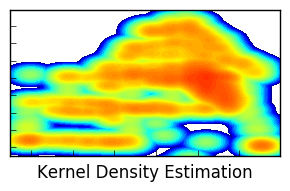

In [12]:
plt.figure(figsize=(3,2), dpi=200)
plt.contourf(X,Y,Z, 
             levels=np.hstack([np.arange(-25,-15,1),np.arange(-15, 0, .3)]))
# plt.hexbin(
#     df[[4]], df[[6]], 
#     extent=(-50,80,-5,80), gridsize=40, 
#     linewidths=(.2,), norm=matplotlib.colors.LogNorm(), cmap='Greys')
plt.xlabel("Kernel Density Estimation", size=12)
# plt.xlabel("A4")
# plt.ylabel("A6")
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left='on',
    right='off',
    labelleft='off',
    labelbottom='off') # labels along the bottom edge are off
plt.tight_layout()
# plt.savefig("shuttlekde_filled.pdf")
plt.savefig("shuttlekde_filled.png",dpi=300)

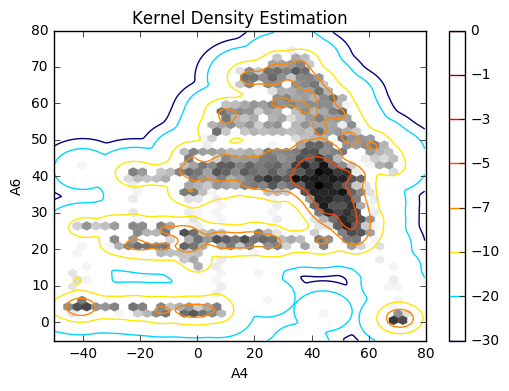

In [11]:
plt.contour(X,Y,Z,levels=[-30, -20, -10, -7, -5, -3, -1, 0])
plt.colorbar()
plt.hexbin(
    df[[4]], df[[6]], 
    extent=(-50,80,-5,80), gridsize=40, 
    linewidths=(.2,), norm=matplotlib.colors.LogNorm(), cmap='Greys')
plt.title("Kernel Density Estimation")
plt.xlabel("A4")
plt.ylabel("A6")
plt.savefig("shuttlekde.pdf")

In [23]:
scores = kde.score_samples(data)

In [24]:
np.percentile(scores, 0.01)

-11.943029112603082

In [25]:
np.percentile(scores, 0.20)

-9.9671337985706252

x = np.arange(-50,80,.25)
y = np.arange(-5,80,.25)
X,Y = np.meshgrid(x,y,indexing="ij")
Z = np.zeros((len(x),len(y)))
for i in range(len(x)):
    for j in range(len(y)):
        Z[i,j]=kde.score_samples([[X[i,j],Y[i,j]]] / bw)[0]

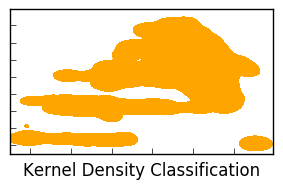

In [10]:
plt.figure(figsize=(3,2))
plt.contourf(X,Y,Z,levels=[-1000, -10, 0], colors=['w','orange','k'])
plt.xlabel("Kernel Density Classification", size=12)
plt.tick_params(
    which='both',      # both major and minor ticks are affected
    bottom='on',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    left='on',
    right='off',
    labelleft='off',
    labelbottom='off') # labels along the bottom edge are off
plt.tight_layout()
plt.savefig("shuttlekde_classify.pdf")